In [ ]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

In [ ]:
!pip install -U kaleido

In [1]:
from os.path import join

import anndata
import scanpy as sc
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [3]:
cols = [
    'dataset_id', 
    'assay', 
    'cell_type', 
    'development_stage', 
    'disease', 
    'tissue', 
    'tissue_general', 
    'tech_sample'
]

obs_train = dd.read_parquet(join(PATH, 'train'), columns=cols, split_row_groups=True).compute()
obs_val = dd.read_parquet(join(PATH, 'val'), columns=cols, split_row_groups=True).compute()
obs_test = dd.read_parquet(join(PATH, 'test'), columns=cols, split_row_groups=True).compute()
obs = pd.concat([obs_train, obs_val, obs_test]).reset_index(drop=True)


cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tissue.parquet'))
disease_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/disease.parquet'))
assay_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/assay.parquet'))

# Summary plot of data

In [4]:
len(obs)

22189056

In [5]:
obs.dataset_id.nunique()

249

In [6]:
obs.disease.nunique()

52

In [7]:
obs.cell_type.nunique()

164

In [8]:
obs.tissue_general.nunique()

56

In [9]:
obs.tech_sample.nunique()

5052

In [11]:
obs_plot = (
    obs[['tissue_general', 'cell_type', 'tech_sample']]
    .groupby(['tissue_general', 'cell_type'])['tech_sample']
    .nunique()
    .reset_index()
    .rename(columns={'tech_sample': 'n_donors'})
)
obs_plot

,tissue_general,cell_type,n_donors
0,0,0,5
1,0,22,5
2,0,54,5
3,0,63,5
4,0,74,5
...,...,...,...
1483,55,127,1
1484,55,129,1
1485,55,138,1
1486,55,142,1


In [12]:
n_donors_per_celltype = (
    obs[['cell_type', 'tech_sample']]
    .groupby('cell_type')['tech_sample']
    .nunique()
    .to_dict()
)

In [13]:
n_diseases_per_celltype = (
    obs[['cell_type', 'disease']]
    .groupby('cell_type')['disease']
    .nunique()
    .to_dict()
)

In [14]:
obs_plot['tissue_general'] = tissue_general_mapping.iloc[obs_plot.tissue_general].to_numpy()
# obs_plot['cell_type'] = cell_type_mapping.iloc[obs_plot.cell_type].to_numpy()
obs_plot['n_donors_per_cell_type'] = obs_plot['cell_type'].replace(n_donors_per_celltype)
obs_plot['n_diseases_per_celltype'] = obs_plot['cell_type'].replace(n_diseases_per_celltype)

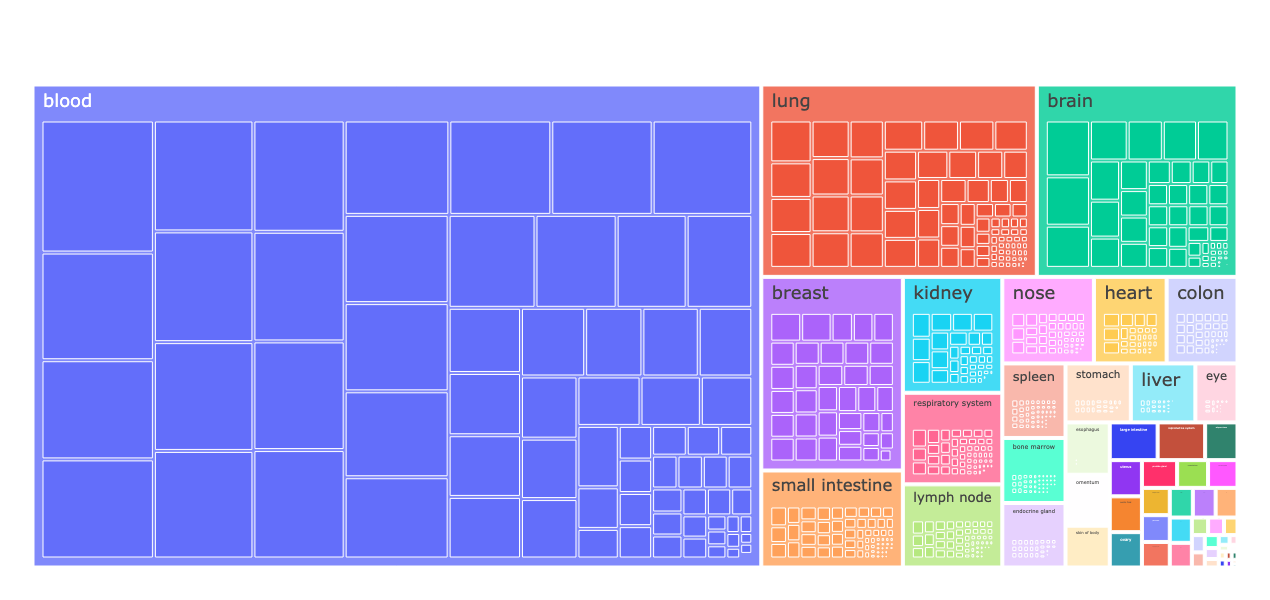

In [24]:
import plotly.express as px
import plotly.io as pio


fig = px.treemap(
    obs_plot, 
    path=['tissue_general', 'cell_type'],
    values='n_donors',
    # color='tissue_general'
)
fig.update_layout(
    width=600,   # Width of the figure in pixels
    height=600,  # Height of the figure in pixels
)
fig.update_layout(
    font={'size': 18},
    uniformtext=dict(minsize=18),
    margin = dict(t=50, l=25, r=25, b=25)
)
fig.update_layout(coloraxis_colorbar_title=None)
fig.update_traces(textinfo='none')
fig.show()
pio.write_image(fig, '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/data-summary-simple.png', scale=3)
pio.write_image(fig, '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/data-summary-simple.pdf')

# Distribution of donors with repect to unique cell types + number of cells

In [10]:
df = pd.DataFrame({
    'number of unique cell types': obs[['tech_sample', 'cell_type']].groupby('tech_sample')['cell_type'].nunique(),
    'number of cells': obs.tech_sample.value_counts().sort_index()
})
df

,number of unique cell types,number of cells
0,10,10074
1,3,7680
2,3,9680
3,2,4911
4,2,4236
...,...,...
5047,3,833
5048,3,791
5049,8,5727
5050,7,9761


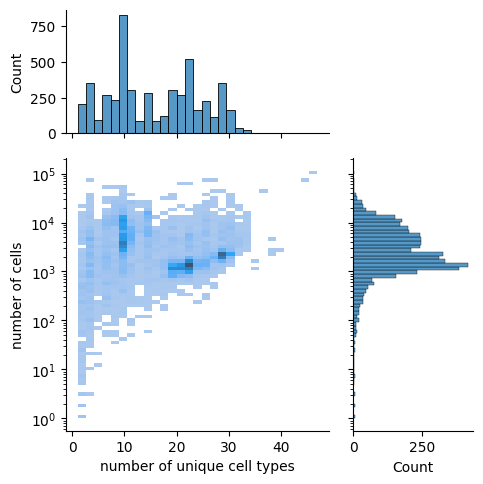

In [11]:
g = sns.jointplot(
    data=df, 
    x='number of unique cell types', 
    y='number of cells', 
    log_scale=(False, True), 
    kind='hist',
    ratio=2,
    height=5.,
    marginal_ticks=True
)

g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/donor_distribution.pdf', format='pdf')
g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/donor_distribution.png', format='png', dpi=300)

# Summary table

In [34]:
summary_table = (
    obs[['tissue_general', 'cell_type', 'tech_sample']]
    .groupby(['tissue_general', 'cell_type'])['tech_sample']
    .agg(['nunique', 'count'])
    .reset_index()
    .rename(columns={'tech_sample': 'n_donors', 'nunique': 'n_donors', 'count': 'n_cells'})
)
summary_table['tissue_general'] = tissue_general_mapping.iloc[summary_table.tissue_general].to_numpy()
summary_table['cell_type'] = cell_type_mapping.iloc[summary_table.cell_type].to_numpy()

summary_table[['cell_type', 'tissue_general', 'n_donors', 'n_cells']].sort_values(['cell_type', 'tissue_general'])

,cell_type,tissue_general,n_donors,n_cells
0,B cell,abdomen,5,384
8,B cell,abdominal wall,1,17
29,B cell,adrenal gland,2,68
37,B cell,ascitic fluid,25,3036
45,B cell,axilla,1,30
...,...,...,...,...
1198,vein endothelial cell,respiratory system,23,4748
1326,vein endothelial cell,small intestine,36,3166
1425,vein endothelial cell,stomach,25,983
1434,vein endothelial cell,tongue,2,217


In [35]:
(
    summary_table[['cell_type', 'tissue_general', 'n_donors', 'n_cells']]
    .sort_values(['cell_type', 'tissue_general'])
    .to_csv('supp_table_donors_and_cells_per_tissue+cell_type.csv')
)